## AGCDv1 ~ LDsss correlation (1900 - 2016) 

Steps: 

AGCD dataset
#1. Load AGCD v1 data (netcdf - lat,lon,time)
#2. calculate seasonal averages (NDJF)


Law Dome dataset
#1. Load timeseries
#2. convert to xarray for correlation - repeat each observation across Lat/Lon of AGCD dataset -> time to equal seasonal period ID in AGCD

Correlation between 2 xarray datasets

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy as cart
import matplotlib.pyplot as plt
import numpy as np
from os import path
from pathlib import Path

%matplotlib inline

## Load AGCDv1 dataset - precipitation

In [2]:
#Load AGCD v1 daily data
ds = xr.open_mfdataset('/g/data/zv2/agcd/v1/precip/total/r005/01day/agcd_v1_precip_total_r005_daily_*.nc',
                       combine = 'nested',concat_dim='time')
ds

<xarray.Dataset>
Dimensions:    (time: 43981, lat: 691, lon: 886, nv: 2)
Coordinates:
  * time       (time) datetime64[ns] 1900-01-01T09:00:00 ... 2020-05-31T09:00:00
  * lat        (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon        (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Dimensions without coordinates: nv
Data variables:
    lat_bnds   (time, lat, nv) float32 dask.array<chunksize=(365, 691, 2), meta=np.ndarray>
    lon_bnds   (time, lon, nv) float32 dask.array<chunksize=(365, 886, 2), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
    precip     (time, lat, lon) float32 dask.array<chunksize=(365, 691, 886), meta=np.ndarray>
    crs        (time) int32 -2147483647 -2147483647 ... -2147483647 -2147483647
Attributes: (12/33)
    geospatial_lat_min:        -44.525
    geospatial_lat_max:        -9.975
    geospatial_lon_min:        111.975
    geospatial_lon_max:        156.275
    time_coverage_start:       1899-12-31T09:00:00
    date_created:              2017-01-17T22:13:51.976225
    ...                        ...
    licence:                   Data Licence: The grid data files in this AGCD...
    description:               This AGCD data is a snapshot of the operationa...
    date_issued:               2020-12-02 05:42:26
    attribution:               Data should be cited as : Australian Bureau of...
    copyright:                 (C) Copyright Commonwealth of Australia 2020, ...
    history:

In [3]:
#subset slice of time - November 1900 to Feb 2016
precip = ds.precip.sel(time = slice('1900-11-01','2016-02-29'))
precip

<xarray.DataArray 'precip' (time: 42124, lat: 691, lon: 886)>
dask.array<getitem, shape=(42124, 691, 886), dtype=float32, chunksize=(366, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-11-01T09:00:00 ... 2016-02-29T09:00:00
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Attributes:
    cell_methods:                  time: sum
    units:                         mm
    analysis_version_number:       3.01
    long_name:                     Daily precipitation
    number_of_stations_reporting:  2757
    standard_name:                 lwe_thickness_of_precipitation_amount
    frequency:                     daily
    length_scale_for_analysis:     80.0
    grid_mapping:                  crs
    coverage_content_type:         physicalMeasurement
    valid_range:                   [     0. 100000.]

In [4]:
#resample to monthly
Mpr= precip.resample(time = 'M').sum()
Mpr

<xarray.DataArray 'precip' (time: 1384, lat: 691, lon: 886)>
dask.array<stack, shape=(1384, 691, 886), dtype=float32, chunksize=(1, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-11-30 1900-12-31 ... 2016-02-29
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2

In [5]:
#running sum - 4 months -> calculates total precip for each 4 month period - 
#label for each period is the final month - e.g. Nov1979-Feb1980 is labelled Feb1980
Spr = Mpr.rolling(time=4).sum().dropna('time')

In [6]:
Spr.shape

(1381, 691, 886)

In [10]:
#select NDJF
Spr_NDJF = Spr.isel(time = (Spr.time.dt.month ==2))
Spr_NDJF

<xarray.DataArray 'precip' (time: 116, lat: 691, lon: 886)>
dask.array<getitem, shape=(116, 691, 886), dtype=float32, chunksize=(1, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1901-02-28 1902-02-28 ... 2016-02-29
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2

In [11]:
#save netcdf
import os
folder_out = '/g/data1a/v45/du2523/Monthly_calcs/'
fn = 'AGCDv1_NDJF_total_precip_1900-2016.nc'
Spr_NDJF.to_netcdf(os.path.join(folder_out, fn))

## Load LDsss data

In [22]:
#load LDsss text file -> 
import pandas as pd

LDsss = pd.read_csv('/g/data1a/v45/du2523/ice_core_data/LawDome_DSS/LDsss_DJFM_1900_2016_vOct21_Jongetal.csv',
                   parse_dates=['JanYear'],
                   dayfirst = True)
#remove top row
LDsss = LDsss.iloc[1:]

LDsss.head()


,JanYear,LDsss_DJFM
1,1901-01-01,0.234373
2,1902-01-01,0.256093
3,1903-01-01,0.024861
4,1904-01-01,-0.011993
5,1905-01-01,0.107100


In [23]:
#set up parameters to create dataset from timeseries

lons = Spr_NDJF.lon.values
lats = Spr_NDJF.lat.values

LDsss_dates_col = LDsss.loc[:,'JanYear']
LDsss_dates = LDsss_dates_col.values

LDsss_conc_col = LDsss.loc[:,'LDsss_DJFM']
LDsss_conc = LDsss_conc_col.values
LDsss_conc.size

116

In [24]:
#AGCD dataset is time, lat, lon
nlons = lons.size
nlats = lats.size
ntime = LDsss_dates.size

LDsss_arr = np.zeros((ntime,nlats,nlons))
LDsss_arr.shape

(116, 691, 886)

In [25]:
LDsss_arr = np.zeros((ntime,nlats,nlons))
LDsss_fill = np.zeros((ntime,nlats,nlons))

n = LDsss_dates.size
for i in range(n):
    x = LDsss_conc[i]
    tmp = LDsss_arr[i,:,:]
    tmp[tmp == 0] = x
    LDsss_fill[[i]] = tmp

LDsss_fill.shape

(116, 691, 886)

In [26]:
#extract time from netcdf dataset to match for correlation
dates = Spr_NDJF.time
dates.shape

(116,)

In [27]:
#create an xarray dataset from the LDsss timeseries - using time, lat, lon from the netcdf dataset

ds_icecore = xr.Dataset({
    'LDsss':xr.DataArray(
        data = LDsss_fill, #enter data here - array must be the same size as the time, lat, lon dims/coords
        dims = ["time","lat","lon"],
        coords = {'time': dates,
                 'lat': lats,
                 'lon': lons},
        attrs = {
            '_FillValue':-999.9,
            'units': 'logCl'
        }
    )
}
)
ds_icecore

<xarray.Dataset>
Dimensions:  (time: 116, lat: 691, lon: 886)
Coordinates:
  * time     (time) datetime64[ns] 1901-02-28 1902-02-28 ... 2016-02-29
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Data variables:
    LDsss    (time, lat, lon) float64 0.2344 0.2344 0.2344 ... 0.3387 0.3387

In [28]:
#save netcdfs
#import os
folder_out = '/g/data1a/v45/du2523/Monthly_calcs/'
fn = 'LDsss_DJFM_1900-01_to_2015-16.nc'
ds_icecore.to_netcdf(os.path.join(folder_out, fn))

## Detrend

In [30]:
#Detrend function

def detrend_dim(da, dim, deg = 1):
    #detrend along a single dimension
    p = da.polyfit(dim = dim, deg = deg)
    fit = xr.polyval(da[dim],p.polyfit_coefficients)
    return da - fit

In [31]:
dSpr_NDJF = detrend_dim(Spr_NDJF,"time",1)

In [32]:
#LDsss
#extract data array from the new dataset (needs to be data array not dataset for correlation to work)
LDsss_val = ds_icecore.LDsss
dLDsss = detrend_dim(LDsss_val,"time",1)

## Correlation

In [33]:
#correlation on detrended datasets
dcorr = xr.corr(dLDsss,dSpr_NDJF, dim = "time")

In [35]:
dcorr.shape

(691, 886)

In [36]:
#save correlation grid
folder_out = '/g/data1a/v45/du2523/Monthly_calcs/'
fn = 'LDsss_AGCDv1_dcorr_1900-01_to_2015-16.nc'
dcorr.to_netcdf(os.path.join(folder_out, fn))

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [39]:
maxcorr = dcorr.max().values
mincorr = dcorr.min().values
mincorr, maxcorr

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


(array(-0.31755953), array(0.4027038))

#### Significance

In [37]:
#calculate signficance of correlation 
from scipy import stats
#degrees of freedom (sample size - number of parameters)
ntime = dLDsss.shape[0]
sample_size = ntime
degF = sample_size - 2

dsig = xr.DataArray(data = dcorr.values*np.sqrt((ntime-2)/1-np.square(dcorr.values)),
                   dims = ["lat","lon"],
                   coords = [dcorr.lat,dcorr.lon])
t90 = stats.t.ppf(1-0.05, ntime-2)
t95 = stats.t.ppf(1-0.025, ntime-2)   

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [40]:
ntime

116

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


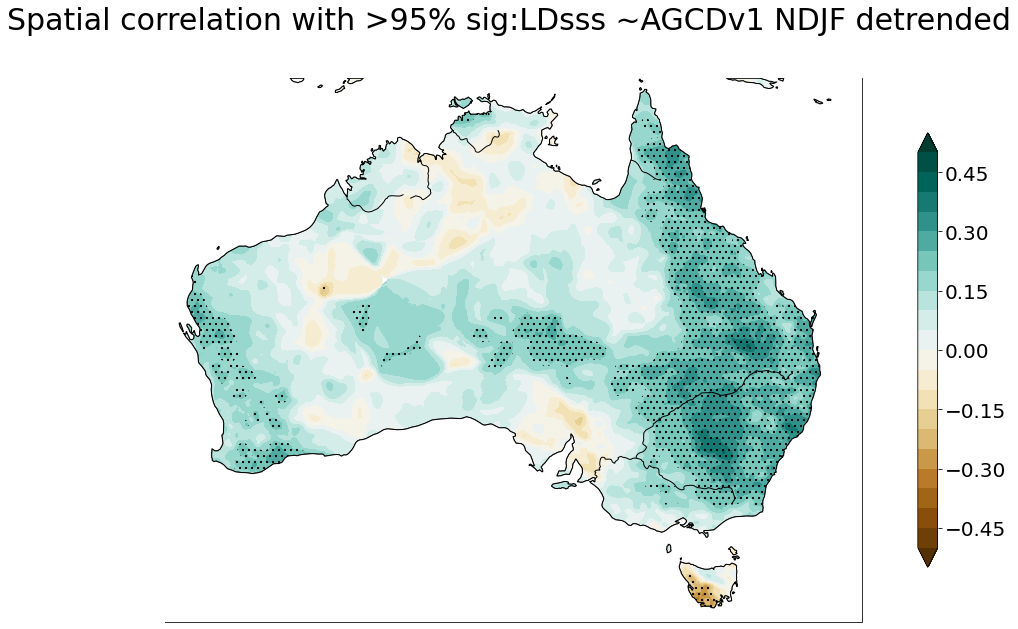

In [42]:
#Plot correlation results with significance shaded

output = '/g/data/v45/du2523/'

fig = plt.figure(figsize = [20,10])
ax = fig.add_subplot(111, projection = ccrs.PlateCarree())

levels = np.arange(-0.5,0.55,0.05)
var = 'LDsss'
ID = 'AGCDv1_NDJF_corr_detrend_sig95_p5scale'
region = 'Aus'

#either corr or dcorr

cp = dcorr.plot.contourf(ax = ax,
                        levels = levels,
                        extend = 'both',
                        cmap = 'BrBG',
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False)

cb = fig.colorbar(cp, ax = ax, shrink = 0.8)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)

#either sig or dsig                      
sig_hatch = dsig.plot.contourf(ax = ax,
                 levels = [-1*t95,-1*t90,t90,t95],
                 colors = 'none',
                 hatches = ['..',None,None,None,'..'],
                 extend = 'both',
                 add_colorbar = False,
                 transform = ccrs.PlateCarree())
    
ax.coastlines()
ax.add_feature(cart.feature.OCEAN,zorder=100, edgecolor='k', facecolor = 'w')
ax.add_feature(cart.feature.RIVERS,zorder=100,edgecolor='k')
    
fig.suptitle('Spatial correlation with >95% sig:'+ var + ' ~AGCDv1 NDJF detrended',fontsize = 30)
 
#save figure
fig.savefig(output + var + '_'+ ID + '_' + region  +'.jpg')